## Case: e-mail classification
Service departments are often providing a central e-mailadres to their (internal or external) customers for reporting issues. Often, different topics are handled by different people or departments. Wouldn’t it be great to have an automatic e-mail classifier that forwards e-mails to the right person? Let’s try to make this.  
  
We start from a set of 9.820 real e-mails originating from several e-mail services like monster.com, nieuwsblad.be, datanews.be, etc.. The e-mails belong to four categories: _advertisements_ , _job offerings_ , _news_ and _ICT_ . We’d like to create a classifier that can be used to automatically classify e-mails into one of the four categories ADS, JOB, NEWS and ICT. 
We start by importing and exploring the data. 


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)  # set width of column output

ads = pd.read_csv('data/emailads.csv',encoding = "ISO-8859-1")
ict = pd.read_csv('data/emailict.csv',encoding = "ISO-8859-1")
job = pd.read_csv('data/emailjob.csv',encoding = "ISO-8859-1")
news = pd.read_csv('data/emailnews.csv',encoding = "ISO-8859-1")

# Merge data
email = ads.append([ict,job,news])

# Combine Subject and Body into a single field "Text"

email = email[['Subject','Body','Category']]  # we only keep these three columns 
email['Text'] = email['Subject'] + ' ' + email['Body']
email = email.drop(['Subject','Body'],axis=1)

# Explore the data
print(email.shape)
print(email.count())
print(email.groupby('Category').count())
print(email.head(10))

(9820, 2)
Category    9820
Text        9820
dtype: int64
          Text
Category      
ADS       2484
ICT       1363
JOB       1582
NEWS      4391
  Category  \
0      ADS   
1      ADS   
2      ADS   
3      ADS   
4      ADS   
5      ADS   
6      ADS   
7      ADS   
8      ADS   
9      ADS   

                                                                                                                                                                                                      Text  
0  Alles halve prijs - of nog veel goedkoper!  <https://www.groupon.be/analytic/trackintl.gif?p=1&utm_domain=telenet.be&nlp=&CID=BE&utm_source=channel_goods-deals&utm_medium=email&sid=8bb46cec-d83a-4...  
1  Alles halve prijs - of nog veel goedkoper!  <https://www.groupon.be/analytic/trackintl.gif?p=1&utm_domain=telenet.be&nlp=&CID=BE&utm_source=channel_goods-deals&utm_medium=email&sid=8bb46cec-d83a-4...  
2  Wat krijgen we nu?! Weer EXTRA korting?  <https://www.groupon.be/analytic/tracki

Since stop word removal and stemming are language dependent we need to first determine the language of each e-mail and split the data set per language. 

In [2]:
# language detection - this can take a while
from langdetect import detect

email['Lang'] = email['Text'].apply(detect)
pd.pivot_table(email, values='Text', index=['Category'],columns=['Lang'], aggfunc='count').fillna(0)

Lang,ca,de,en,fr,it,nl
Category,,,,,,
ADS,51.0,112.0,757.0,4.0,1.0,1559.0
ICT,0.0,0.0,1140.0,0.0,0.0,223.0
JOB,0.0,14.0,946.0,5.0,0.0,617.0
NEWS,0.0,6.0,13.0,0.0,0.0,4372.0


Although we know only dutch, english and french emails occur in our dataset a number of other languages are detected, probably because of the frequent use of URL's in the e-mails that is confusing the detect method. Let's check this.

In [3]:
emailnl = email[email['Lang'] == "nl"]
emailfr = email[email['Lang'] == "fr"]
emailen = email[email['Lang'] == "en"]

pd.set_option('display.max_colwidth', 200)
print(emailnl.head(20))
print(emailfr.tail(20))
print(emailen.tail(20))

   Category  \
0       ADS   
1       ADS   
2       ADS   
3       ADS   
4       ADS   
5       ADS   
6       ADS   
7       ADS   
8       ADS   
9       ADS   
10      ADS   
11      ADS   
12      ADS   
13      ADS   
14      ADS   
15      ADS   
16      ADS   
17      ADS   
18      ADS   
19      ADS   

                                                                                                                                                                                                       Text  \
0   Alles halve prijs - of nog veel goedkoper!  <https://www.groupon.be/analytic/trackintl.gif?p=1&utm_domain=telenet.be&nlp=&CID=BE&utm_source=channel_goods-deals&utm_medium=email&sid=8bb46cec-d83a-4...   
1   Alles halve prijs - of nog veel goedkoper!  <https://www.groupon.be/analytic/trackintl.gif?p=1&utm_domain=telenet.be&nlp=&CID=BE&utm_source=channel_goods-deals&utm_medium=email&sid=8bb46cec-d83a-4...   
2   Wat krijgen we nu?! Weer EXTRA korting?  <https://www.group

We see that indeed a number of Dutch e-mails are incorrectly labelled as English. We decide to create a model for the Dutch e-mails only. In practice, you could try to remove all hyperlinks.  
  
Now we can **remove stop words and punctuations**. For removing stop words we can use the Python library NLTK (Natural Language Toolkit, see (NLTK 3.4.5 documentation, sd)), that contains all kinds of functions for handling natural language in Python. 
We apply the remove_stopwords_nl function to each message. This function splits the string into separate words (“tokens”) and only keeps the words that are not digits, not punctuation marks and not stop words. 

In [4]:
# remove stopwords and punctuations
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
    
stop_words_nl = set(stopwords.words('dutch')) 

punctuations="?:!.,;<>/\+-"

# define functions to remove digits stopwords from a string
# I know we are copy-pasting code, but this is for now the simpliest way

def remove_stopwords_nl(s):
    word_tokens = word_tokenize(s) # turn the string into a list of words based on separators (blank, comma, etc.)
    filtered_sentence = ""
    for w in word_tokens: 
        if ~(w.isdigit()) & (w not in stop_words_nl) & (w not in punctuations): 
            filtered_sentence += ' ' + w
    return filtered_sentence

emailnl['Text'] = emailnl['Text'].apply(remove_stopwords_nl)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcor864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\jcor864\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
pd.set_option('display.max_colwidth', 400)
print(emailnl.head(20))

   Category  \
0       ADS   
1       ADS   
2       ADS   
3       ADS   
4       ADS   
5       ADS   
6       ADS   
7       ADS   
8       ADS   
9       ADS   
10      ADS   
11      ADS   
12      ADS   
13      ADS   
14      ADS   
15      ADS   
16      ADS   
17      ADS   
18      ADS   
19      ADS   

                                                                                                                                                                                                                                                                                                                                                                                                               Text  \
0    Alles halve prijs goedkoper https //www.groupon.be/analytic/trackintl.gif p=1 & utm_domain=telenet.be & nlp= & CID=BE & utm_source=channel_goods-deals & utm_medium=email & sid=8bb46cec-d83a-468a-863b-ce5fb472d663_0_20171109 & t_division=brugge & eh=e308d190475712edb82b289

NLTK also offers stemming. The SnowballStemmer is available for many languages, also for Dutch. 

In [6]:
# Stemming: replace words by stem
from nltk.stem.snowball import SnowballStemmer

dutchStemmer=SnowballStemmer("dutch")

def stemming_nl(s):
    word_tokens = word_tokenize(s) # turn the string into a list of words based on separators (blank, comma, etc.)
    stemmed_sentence = ""
    for w in word_tokens: 
        stemmed_sentence += ' ' + dutchStemmer.stem(w)
    return stemmed_sentence

emailnl['Text'] = emailnl['Text'].apply(stemming_nl)

C:\Users\jcor864\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [7]:
pd.set_option('display.max_colwidth', 400)
print(emailnl.tail(20))

     Category  \
4371     NEWS   
4372     NEWS   
4373     NEWS   
4374     NEWS   
4375     NEWS   
4376     NEWS   
4377     NEWS   
4378     NEWS   
4379     NEWS   
4380     NEWS   
4381     NEWS   
4382     NEWS   
4383     NEWS   
4384     NEWS   
4385     NEWS   
4386     NEWS   
4387     NEWS   
4388     NEWS   
4389     NEWS   
4390     NEWS   

                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
4371   nieuw antwerp coalitie gat 'grot verbind ' vtm nieuw updat n-va sp.a open vld ontwerp-bestuursakkoord http //ims.vtmnieuws.be/optiext/optiextension.dll id=ijbmmq1mdl506r70oyp_kgpbz3grdufbflipbuawqil2quozgwtvct4slhrkuadqvjddlkq

As usual we split the data set into a training and test set. 

In [8]:
# Split in test and training set
from sklearn.model_selection import train_test_split
X = emailnl.drop('Category',axis=1)
y = emailnl['Category']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

The **TFidfVectorizer** is a great tool from Scikit-Learn to calculate the tf-idf score for each distinct word in the complete data set (in this case the training set X_train). It creates a matrix in which the number of rows equals the number of documents (in this case the e-mails in the training set) and the number of columns equals the number of distinct words in the complete set of documents. Each cell contains the tfidf score for the corresponding word in the corresponding document.  
  
The function **get_feature_names()** of **TFidfVectorizer** return all the differents words in the document set.  
  
If you would like to use the raw word count instead of the tfidf score you could use **CountVectorizer**. 

In [9]:
# Apply TfidVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(X_train['Text'])
print(len(vec.get_feature_names()))

583552


We see we have 573917 different words in the training set. Due to the heavy use of URL’s and other codes in the training set many of those “words” are probably not words of the natural language.   
  
We are now ready for building the model. We use a concept that often occurs in machine learning: **pipelines**. This allows us to combine several operations into a single compound operation (“a pipeline”). We use it to combine the TfidVectorizer and the VotingClassifier, we used before, into a pipeline. Due to the uniform API of all Scikit-learn classes the output of the TfidVectorizer is compatible with the input of the VotingClassifier. 

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

lr = LogisticRegression(solver='newton-cg')
rf = RandomForestClassifier(n_estimators=150)
nb =  MultinomialNB()

voting = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('mnb', nb)], voting='hard')
model = make_pipeline(TfidfVectorizer(), voting)

model.fit(X_train["Text"], y_train)
categories = model.predict(X_test["Text"])

Let's determine the accuracy of the model. 

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, categories)*100)

99.60629921259843


We get an amazing accuracy of over 99.5 %!  
  
This is confirmed by the confusion matrix that shows only very few messages are "off-diagonal". This high score is probably due to the fact that all e-mails in the input data set are coming from professional, streamlined sources, that have fixed structures, clear topics (e.g. only job openings) and no spelling errors. E-mails written by humans to a e.g. help desk might contain spelling errors and topics might be more confuse or mixed. 

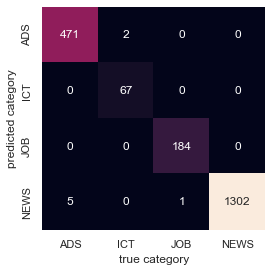

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.style.use('classic')
%matplotlib inline
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test, categories)

labels = ['ADS','ICT','JOB','NEWS']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category');

Finally we can write a function to classify an unseen e-mail text. This function can then be integrated as an inbox rule in the e-mail program. This step is called deployment of the model and the corresponding workload might not be underestimated.

In [13]:
def predict_category(s, model=model):
    s = remove_stopwords_nl(s)
    s = stemming_nl(s)
    pred = model.predict([s])
    return pred[0]

print(predict_category("Pauwels consulting is looking for an experienced PHP back- end developer to complete its development team . "))
print(predict_category("Terug naar af: na vijf maanden begraaft Magnette een regering met PS én N-VA"))


ADS
NEWS


This model has been trained a few years ago. It might be that over time the nature of some e-mail categories have changed. Therefore it's recommeded that you retrain your model on a regularly basis.